# Import Required Libraries

In [78]:
import numpy as np
np.random.seed(42)

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
sns.set_style("whitegrid")

import pickle
import io
import time
import os
from collections import Counter

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression

from skompiler import skompile

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

from IPython.display import Markdown

def bold(string):
    display(Markdown("**" + string + "**"))

import warnings
warnings.filterwarnings("ignore")

# Load Data

In [79]:
files = os.listdir("./data")
files

['balcony.txt',
 'bathroom.txt',
 'bedroom.txt',
 'kitchen.txt',
 'living_room.txt']

In [80]:
df = pd.DataFrame(columns=["Signal", "Room"])
df

,Signal,Room


In [81]:
for file in files:
    room = file.split(".")[0]
    d = pd.read_csv(f"data/{file}", header=None)
    d.columns = ["Signal"]
    d["Signal"] = d["Signal"].astype(float)
    d["Room"] = room

    df = pd.concat([df, d], axis=0)

In [82]:
df.head()

,Signal,Room
0,-80.00,balcony
1,-78.00,balcony
2,-78.00,balcony
3,-79.00,balcony
4,-81.00,balcony


In [83]:
df.shape

(500, 2)

In [84]:
def df_stats(data):
    bold(" SHAPE ".center(50, "#"))
    print("ROWS: {}".format(data.shape[0]))
    print("COLUMNS: {}".format(data.shape[1]))
    bold(" TYPES ".center(50, "#"))
    print(data.dtypes)
    bold(" MISSING VALUES ".center(50, "#"))
    print(data.isnull().sum())
    bold(" DUPLICATED VALUES ".center(50, "#"))
    print("NUMBER OF DUPLICATED VALUES: {}".format(data.duplicated().sum()))
    bold(" MEMORY USAGE ".center(50, "#"))
    buf = io.StringIO()
    data.info(buf=buf)
    info = buf.getvalue().split("\n")[-2].split(":")[1].strip()
    print("Memory Usage: {}".format(info))
    bold(" DESCRIBE ".center(50, "#"))
    display(data.describe().T)

In [85]:
df_stats(df)

**##################### SHAPE ######################**

ROWS: 500
COLUMNS: 2


**##################### TYPES ######################**

Signal    float64
Room       object
dtype: object


**################# MISSING VALUES #################**

Signal    0
Room      0
dtype: int64


**############### DUPLICATED VALUES ################**

NUMBER OF DUPLICATED VALUES: 406


**################## MEMORY USAGE ##################**

Memory Usage: 11.7+ KB


**#################### DESCRIBE ####################**

,count,mean,std,min,25%,50%,75%,max
Signal,500.00,-68.48,9.48,-86.00,-75.00,-70.50,-63.75,-39.00


In [86]:
df.to_csv('data.csv')

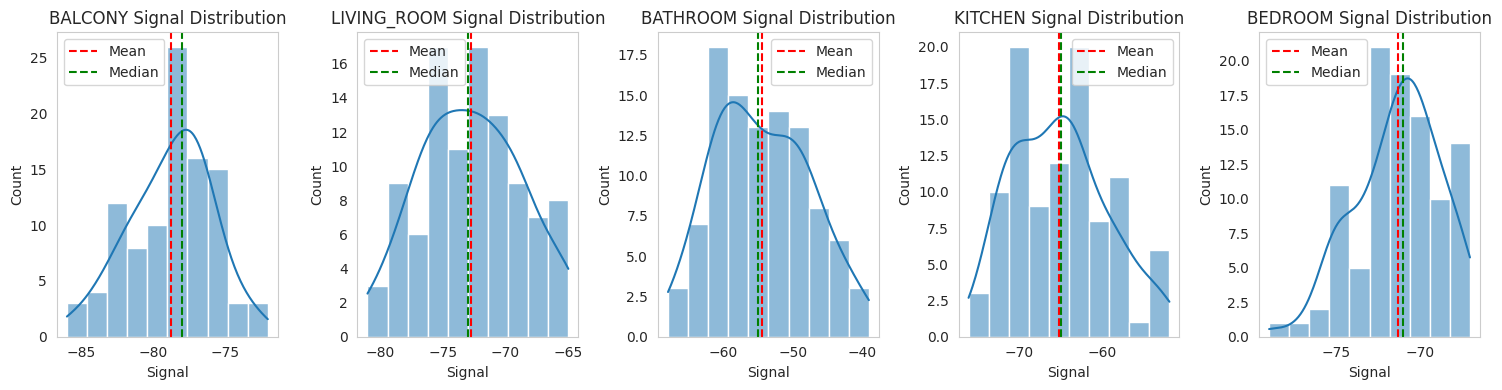

In [87]:
plt.figure(figsize=(15, 4))

rooms = ["balcony", "living_room", "bathroom", "kitchen", "bedroom"]

for i in range(5):
    plt.subplot(1, 5, i + 1)
    temp_df = df[df["Room"] == rooms[i]]
    sns.histplot(x="Signal", data=temp_df, bins=10, kde=True)
    plt.axvline(temp_df["Signal"].mean(), color="r", linestyle="--", label="Mean")
    plt.axvline(temp_df["Signal"].median(), color="g", linestyle="--", label="Median")
    plt.grid()
    plt.title(f"{rooms[i].upper()} Signal Distribution")
    plt.legend()
    plt.tight_layout()

plt.show()

# Model Training

In [88]:
X = df["Signal"].values.reshape(-1, 1)
y = df["Room"].values.reshape(-1, 1)

In [89]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [90]:
# 0 -> balcony
# 1 -> bathroom
# 2 -> bedroom
# 3 -> kitchen
# 4 -> living_room
le.classes_

array(['balcony', 'bathroom', 'bedroom', 'kitchen', 'living_room'],
      dtype=object)

In [91]:
smote = SMOTE(random_state=42, sampling_strategy={i: 500 for i in range(max(y_encoded) + 1)})
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

print("Imbalanced:", Counter(y_resampled))

Imbalanced: Counter({0: 500, 1: 500, 2: 500, 3: 500, 4: 500})


In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42, shuffle=True)

In [103]:
rf = DecisionTreeClassifier()
start = time.time()
rf.fit(X_train, y_train)
end = time.time()
rf_time = end - start
print("Random Forest Train Time:", rf_time)

Random Forest Train Time: 0.0023927688598632812


In [104]:
rf_pred_train = rf.predict(X_train)
rf_pred_test = rf.predict(X_test)

rf_train_score = accuracy_score(rf_pred_train, y_train)
rf_test_score = accuracy_score(rf_pred_test, y_test)
print("Random Forest Train Score:", rf_train_score)
print("Random Forest Test Score:", rf_test_score)

Random Forest Train Score: 0.708
Random Forest Test Score: 0.664


In [105]:
rf_precision_score = precision_score(y_test, rf_pred_test, average="weighted")
rf_f1_score = f1_score(y_test, rf_pred_test, average="weighted")
rf_recall_score = recall_score(y_test, rf_pred_test, average="weighted")
rf_accuracy_score = accuracy_score(y_test, rf_pred_test)

print("Random Forest Precision Score:", rf_precision_score)
print("Random Forest F1 Score:", rf_f1_score)
print("Random Forest Recall Score:", rf_recall_score)
print("Random Forest Accuracy Score:", rf_accuracy_score)

Random Forest Precision Score: 0.6772657894736842
Random Forest F1 Score: 0.6615795130700503
Random Forest Recall Score: 0.664
Random Forest Accuracy Score: 0.664


In [106]:
print(classification_report(y_test, rf_pred_test, target_names=le.classes_))

              precision    recall  f1-score   support

     balcony       0.93      0.82      0.87        45
    bathroom       0.91      0.90      0.90        58
     bedroom       0.49      0.74      0.59        54
     kitchen       0.56      0.40      0.47        45
 living_room       0.47      0.40      0.43        48

    accuracy                           0.66       250
   macro avg       0.67      0.65      0.65       250
weighted avg       0.68      0.66      0.66       250



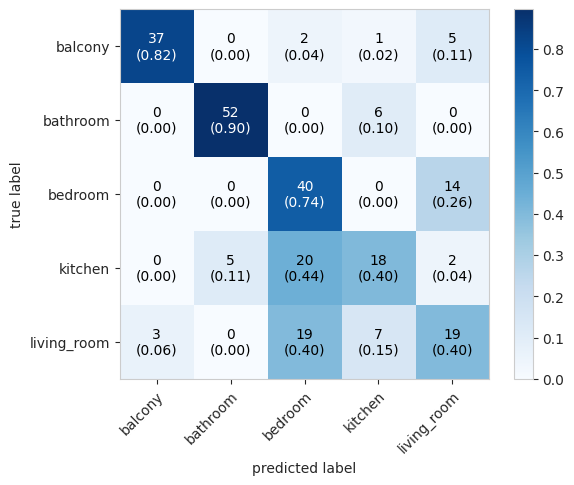

In [107]:
rf_cm = confusion_matrix(y_test, rf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=rf_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=le.classes_)
plt.show()

In [108]:
pickle.dump(rf, open("rf.pkl", "wb"))